In [468]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
from common import common
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [469]:
wandb.login()

True

In [470]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/Users/bytedance/Downloads/work/CS5344_Project/work/common/common.py'>

In [471]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [472]:
# project name should correspond to dataset below
project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"

In [473]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
else:
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()

Normal class:  0    2
Name: Cover_Type, dtype: int32


In [474]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [475]:
all_df.shape

(581012, 55)

In [476]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [477]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [478]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(464809, 54) (116203, 54) (464809,) (116203,)


In [479]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
519924,3289.0,22.0,19.0,240.0,93.0,1708.0,205.0,196.0,122.0,2598.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
318451,2963.0,21.0,18.0,134.0,27.0,1243.0,206.0,200.0,127.0,1140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
22325,3037.0,185.0,9.0,127.0,10.0,6462.0,222.0,246.0,158.0,3037.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
449376,3113.0,203.0,13.0,190.0,22.0,2125.0,213.0,251.0,171.0,730.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
482753,3128.0,346.0,9.0,120.0,36.0,552.0,203.0,226.0,161.0,924.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [480]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [481]:
X_test_scaled_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
250728,1.399198,0.450259,1.723365,2.149461,1.332172,0.937856,-0.753243,1.450972,0.980052,0.219004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
246788,-0.810613,-0.237831,-0.948062,-0.269777,-0.778592,-0.813239,0.704291,0.641599,-0.144387,-0.806331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407714,-1.381808,-1.176136,-0.680920,-0.321550,-0.366736,-0.893388,0.143701,-0.066603,-0.013638,0.158646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25713,-0.482175,-0.774005,-0.146634,0.695094,-0.126486,0.559553,0.779036,-0.471289,-0.850431,3.393092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21820,-1.535316,-0.639962,-1.215205,-0.702792,-0.641307,-0.806827,0.554800,0.388670,-0.092088,2.265148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [482]:
seconds = time.time()

benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 2  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
# Parallel execution to create the anomaly datasets for each anomaly class
# def create_dataset(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels):
#     return common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

# # Using Joblib to parallelize the dataset creation
# results = Parallel(n_jobs=-1)(
#     delayed(create_dataset)(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
#     for label, name in TARGET_DICT.items() if label != NORMAL_TARGET
# )

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747}
Spruce-Fir.csv created with 495141 rows. (283301 benign and 211840 abnormal rows)
PonderosaPine.csv created with 107262 rows. (71508 benign and 35754 abnormal rows)
CottonwoodWillow.csv created with 8241 rows. (5494 benign and 2747 abnormal rows)
Aspen.csv created with 28479 rows. (18986 benign and 9493 abnormal rows)
DouglasFir.csv created with 52101 rows. (34734 benign and 17367 abnormal rows)
Krummholz.csv created with 61530 rows. (41020 benign and 20510 abnormal rows)
All datasets created successfully!
Total operation time: = 4.930325031280518 seconds


In [483]:
len(main_labels)

55

csv_files ['Krummholz.csv', 'CottonwoodWillow.csv', 'DouglasFir.csv', 'Aspen.csv', 'Spruce-Fir.csv', 'PonderosaPine.csv']
Processing CSV file: Krummholz.csv
Krummholz importance list:
Krummholz 
                                     importance
Features                                      
Elevation                             0.817499
Horizontal_Distance_To_Roadways       0.040057
Horizontal_Distance_To_Fire_Points    0.021515
Horizontal_Distance_To_Hydrology      0.018438
Wilderness_Area_1                     0.017404
Vertical_Distance_To_Hydrology        0.007955
Hillshade_Noon                        0.006456
Hillshade_3pm                         0.003865
Aspect                                0.002882
Wilderness_Area_2                     0.002825
Hillshade_9am                         0.002735
Slope                                 0.002192
Wilderness_Area_0                     0.001226
Soil_Type_3                           0.000777
Wilderness_Area_3                     0.000000
Soil_

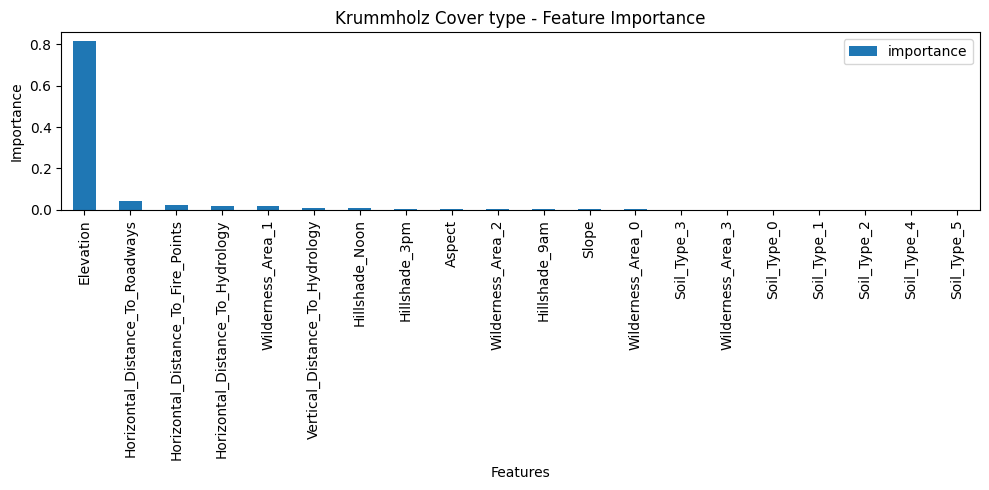

-----------------------------------------------------------------------------------------------




Processing CSV file: CottonwoodWillow.csv
CottonwoodWillow importance list:
CottonwoodWillow 
                                     importance
Features                                      
Elevation                             0.877060
Wilderness_Area_3                     0.110814
Soil_Type_4                           0.002417
Hillshade_9am                         0.001654
Horizontal_Distance_To_Fire_Points    0.001388
Wilderness_Area_2                     0.000874
Horizontal_Distance_To_Roadways       0.000828
Horizontal_Distance_To_Hydrology      0.000651
Hillshade_Noon                        0.000626
Aspect                                0.000603
Vertical_Distance_To_Hydrology        0.000565
Soil_Type_1                           0.000370
Hillshade_3pm                         0.000370
Soil_Type_5                           0.000282
Slope                                 0.000270
Soil_T

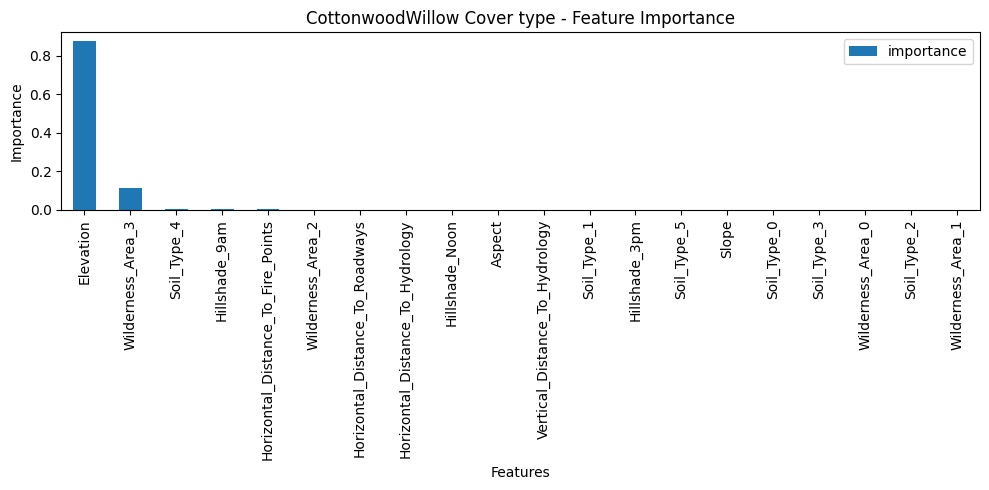

-----------------------------------------------------------------------------------------------




Processing CSV file: DouglasFir.csv
DouglasFir importance list:
DouglasFir 
                                       importance
Features                                        
Elevation                           6.888030e-01
Wilderness_Area_0                   9.159802e-02
Horizontal_Distance_To_Fire_Points  3.672079e-02
Horizontal_Distance_To_Roadways     3.526845e-02
Wilderness_Area_2                   2.907001e-02
Aspect                              2.105391e-02
Vertical_Distance_To_Hydrology      1.827712e-02
Horizontal_Distance_To_Hydrology    9.635025e-03
Hillshade_9am                       8.675519e-03
Hillshade_Noon                      8.020150e-03
Hillshade_3pm                       7.743744e-03
Slope                               4.697196e-03
Soil_Type_2                         3.913216e-03
Wilderness_Area_3                   2.324897e-03
Soil_Type_3                         1.4

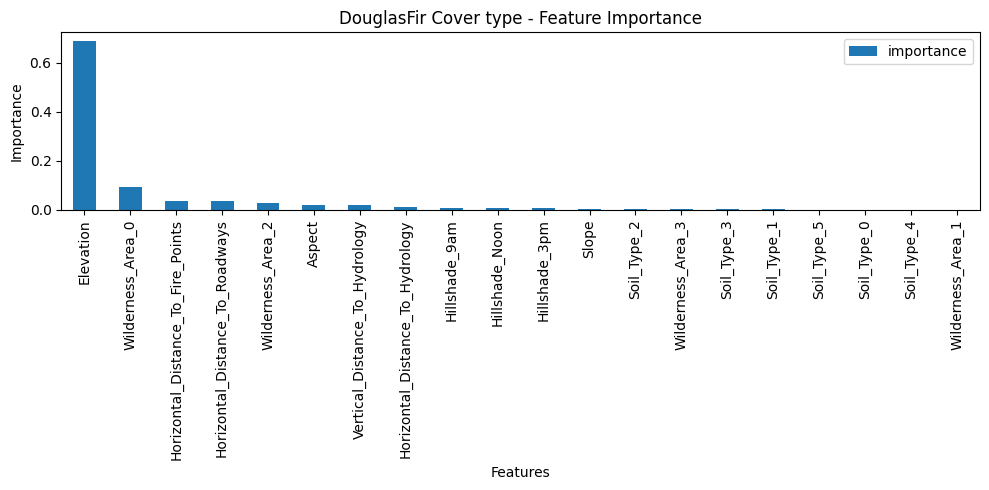

-----------------------------------------------------------------------------------------------




Processing CSV file: Aspen.csv
Aspen importance list:
Aspen 
                                       importance
Features                                        
Elevation                           3.144602e-01
Horizontal_Distance_To_Roadways     1.534825e-01
Horizontal_Distance_To_Fire_Points  1.322122e-01
Hillshade_9am                       4.356084e-02
Horizontal_Distance_To_Hydrology    4.280950e-02
Vertical_Distance_To_Hydrology      3.586052e-02
Hillshade_Noon                      3.494748e-02
Aspect                              3.226458e-02
Hillshade_3pm                       2.363039e-02
Slope                               2.048778e-02
Soil_Type_3                         1.139180e-02
Soil_Type_1                         1.042714e-02
Wilderness_Area_2                   1.014899e-02
Wilderness_Area_0                   4.527133e-03
Soil_Type_2                         1.170069e-03
Wilde

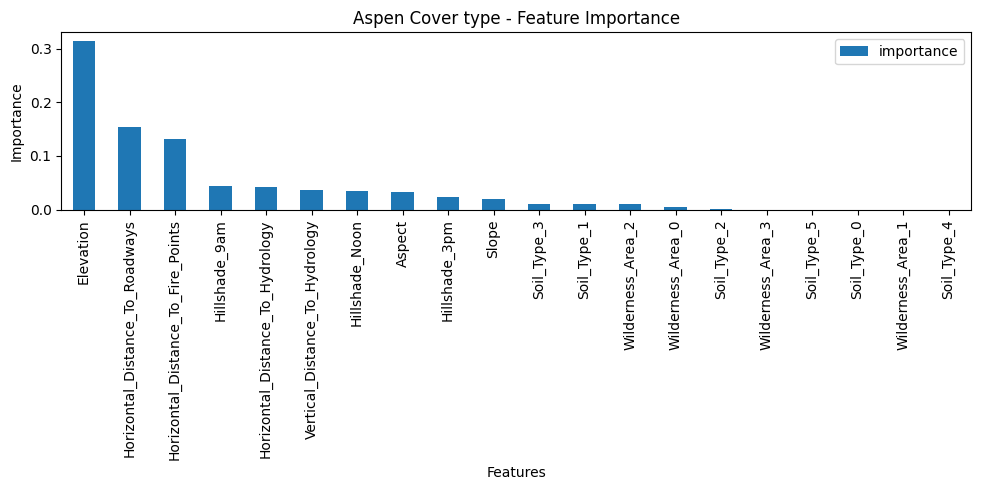

-----------------------------------------------------------------------------------------------




Processing CSV file: Spruce-Fir.csv
Spruce-Fir importance list:
Spruce-Fir 
                                       importance
Features                                        
Elevation                           3.276642e-01
Horizontal_Distance_To_Roadways     1.580131e-01
Horizontal_Distance_To_Fire_Points  1.571243e-01
Horizontal_Distance_To_Hydrology    6.777586e-02
Vertical_Distance_To_Hydrology      4.680999e-02
Hillshade_Noon                      3.912884e-02
Hillshade_9am                       2.848223e-02
Aspect                              2.792639e-02
Hillshade_3pm                       2.181463e-02
Slope                               1.636623e-02
Wilderness_Area_2                   1.054629e-02
Wilderness_Area_0                   8.095573e-03
Wilderness_Area_1                   4.883645e-03
Soil_Type_3                         1.969847e-04
Soil_Type_1                         1.4

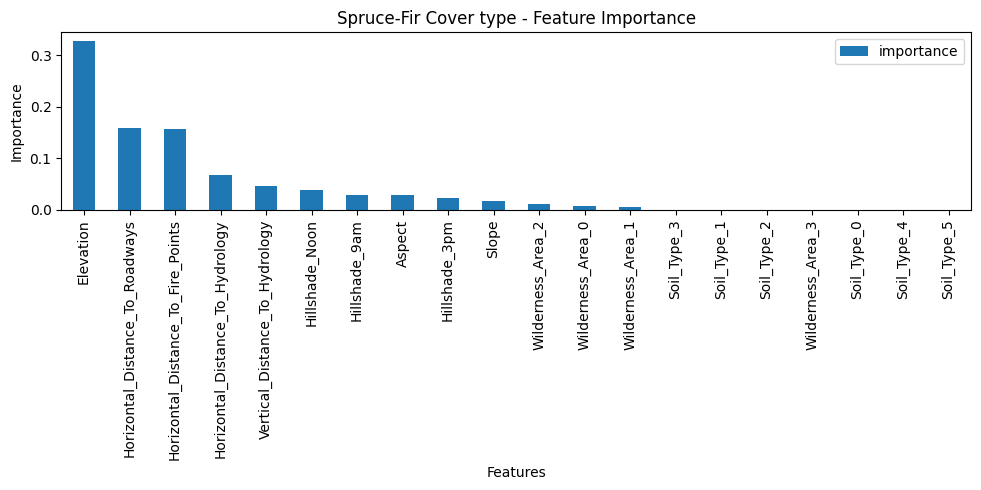

-----------------------------------------------------------------------------------------------




Processing CSV file: PonderosaPine.csv
PonderosaPine importance list:
PonderosaPine 
                                     importance
Features                                      
Elevation                             0.685843
Wilderness_Area_0                     0.091192
Soil_Type_3                           0.046861
Soil_Type_1                           0.044192
Horizontal_Distance_To_Roadways       0.032292
Horizontal_Distance_To_Fire_Points    0.023915
Horizontal_Distance_To_Hydrology      0.012620
Vertical_Distance_To_Hydrology        0.008679
Hillshade_9am                         0.007815
Hillshade_Noon                        0.007192
Aspect                                0.005957
Hillshade_3pm                         0.004832
Slope                                 0.003522
Wilderness_Area_3                     0.001594
Wilderness_Area_2                     0.001351
Soil_Type_2    

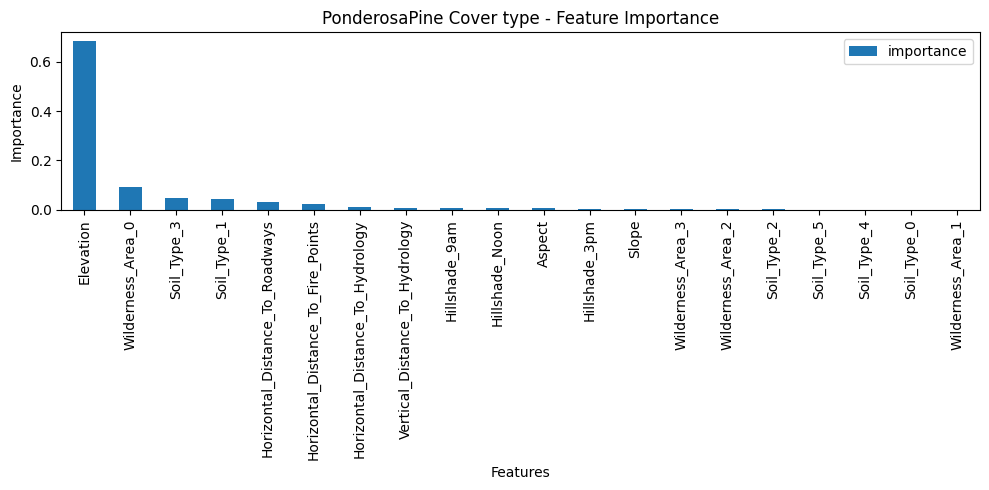

-----------------------------------------------------------------------------------------------




feature_importances: {'Krummholz': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Wilderness_Area_1'], 'CottonwoodWillow': ['Elevation', 'Wilderness_Area_3', 'Soil_Type_4', 'Hillshade_9am', 'Horizontal_Distance_To_Fire_Points'], 'DouglasFir': ['Elevation', 'Wilderness_Area_0', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways', 'Wilderness_Area_2'], 'Aspen': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Hillshade_9am', 'Horizontal_Distance_To_Hydrology'], 'Spruce-Fir': ['Elevation', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], 'PonderosaPine': ['Elevation', 'Wilderness_Area_0', 'Soil_Type_3', 'Soil_Type_1', 'Horizontal_Distance_To_Roadways']}
Total oper

In [484]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

# process_csv_with_args = partial(
#         common.process_csv, 
#         main_labels=main_labels, 
#         target_column=TARGET_COLUMN, 
#         normal_target=NORMAL_TARGET, 
#         numerical_columns=NUMERICAL_COLUMNS, 
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler 
#     )

# with ProcessPoolExecutor() as executor:
#         results = list(executor.map(process_csv_with_args, csv_files))

# # Collect results from the futures
# for label, important_features, svm, impor_bars in results:
#     feature_importances[label] = important_features
#     SVMs[label] = svm

#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [485]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# # Define the parameter grid to search
# param_distributions = {
#     'n_estimators': [100, 200, 300, 400, 500],               # Number of trees
#     'max_depth': [None, 10, 20, 30, 40, 50],                 # Tree depth
#     'min_samples_split': [2, 5, 10],                         # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],                           # Minimum samples at a leaf
#     'max_features': ['auto', 'sqrt', 'log2'],                # Number of features to consider at each split
#     'bootstrap': [True, False]                               # Use bootstrap samples or not
# }

# # Perform random search with cross-validation
# random_search = RandomizedSearchCV(estimator=rf, 
#                                    param_distributions=param_distributions, 
#                                    n_iter=100,  # Number of parameter settings sampled
#                                    cv=3,        # 3-fold cross-validation
#                                    random_state=42, 
#                                    n_jobs=-1)   # Use all cores

# Fit the model
# random_search.fit(X_train_df, y_train_df)

# Best parameters found
# print("Best parameters found: ", random_search.best_params_)
# print("Best score: ", random_search.best_score_)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [1 2 2 ... 2 2 7]
Total operation time: =  11.286646842956543 seconds


Multiclass Classification Evaluation


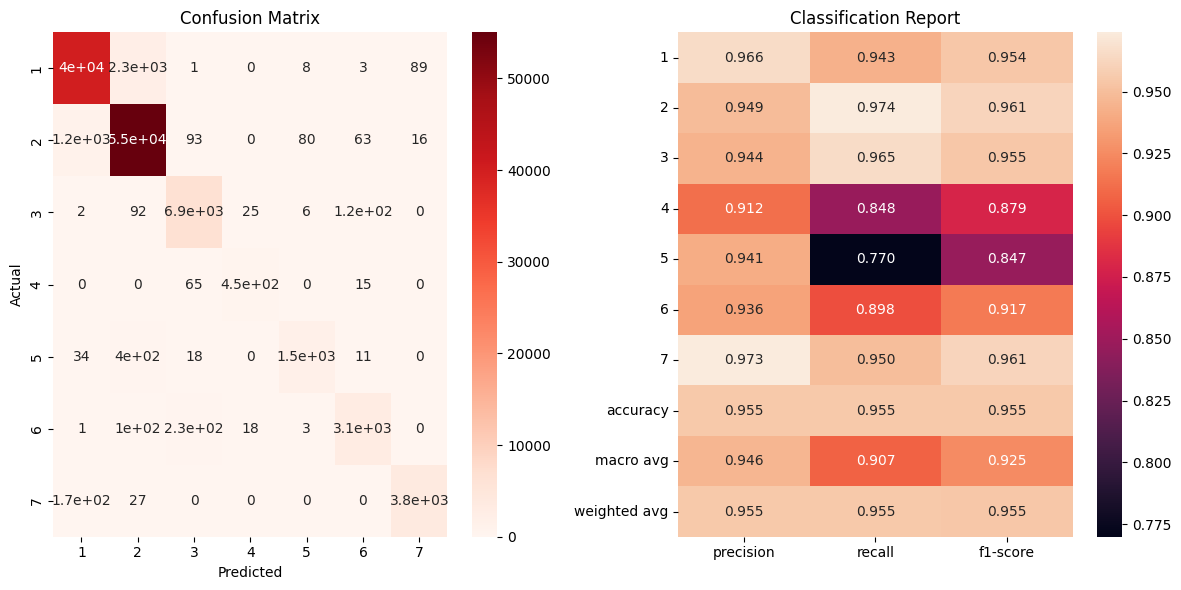

Accuracy: 0.9548978942023872


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.9549
f1-score_avg,0.95465
precision_avg,0.95501
recall_avg,0.9549


In [486]:
pn = "pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [ ]:
knn_predictions = []
seconds = time.time()
THRESHOLD = 0.5
improve_cnt = 0
deprove_cnt = 0

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict_proba(test_instance_selected_df)
    # print(knn_prediction)
    normal_class_prob = knn_prediction[:, 1]
    abnormal_class_prob = knn_prediction[:, 0]
    
    return (abnormal_class_prob, normal_class_prob)

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    
    if test_predictions[i] == NORMAL_TARGET:
        # class_probabilities = {}
        
        # # Test the normal data point with all anomaly models
        # for class_label, svm_model in SVMs.items():
        #     # Select features for the SVM
        #     selected_features = feature_importances[class_label]
        #     test_instance_selected_df = test_instance_df[selected_features]
        #     proba = svm_model.predict_proba(test_instance_selected_df)
            
        #     # We take the probability of class 0 (anomaly class)
        #     anomaly_proba = proba[0][0]
        #     class_probabilities[class_label] = anomaly_proba

        # # Get the class with the highest probability
        # most_probable_class = max(class_probabilities, key=class_probabilities.get)
        
        # # If the highest probability class has a probability greater than a threshold (e.g., 0.5), classify it as anomaly
        # if class_probabilities[most_probable_class] > 0.5:
        #     svm_predictions.append((0, INV_TARGET_DICT[most_probable_class], y_test_df.iloc[i]))
        # else:
            # Otherwise, classify it as normal

        # New method
        # knn_predictions.append((NORMAL_TARGET, y_test_df.iloc[i]))
        # Old method
        knn_predictions.append((1, NORMAL_TARGET, y_test_df.iloc[i]))
    else:
        # New method
        # predicted_label = TARGET_DICT[test_predictions[i]]
        # abnormal_class_prob, normal_class_prob = predict_knn(predicted_label, test_instance_df)
        # max_prob = abnormal_class_prob if abnormal_class_prob > normal_class_prob else normal_class_prob
        # final_class_1 = INV_TARGET_DICT[predicted_label] if abnormal_class_prob > normal_class_prob else NORMAL_TARGET
        # final_class_2 = final_class_1

        # if normal_class_prob < THRESHOLD:
        #     for key, knn in KNNs.items():
        #         if key != predicted_label:
        #             sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
        #             if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
        #                 max_prob = sub_abnormal_class_prob
        #                 final_class_2 = INV_TARGET_DICT[key]

        # status = ''
        # if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
        #     improve_cnt += 1
        #     status = 'improve'
        # if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
        #     deprove_cnt += 1
        #     status = 'deprove'
        # print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, abnormal_class_prob, normal_class_prob)
        # knn_predictions.append((final_class_2, y_test_df.iloc[i]))

        # Old method
        selected_features = feature_importances[predicted_label]
        knn_model = KNNs[predicted_label]
        test_instance_selected_df = test_instance_df[selected_features]
        knn_prediction = knn_model.predict(test_instance_selected_df)
        print(knn_prediction)
        knn_predictions.append((knn_prediction[0], INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))
print('improve_cnt', improve_cnt, 'deprove_cnt', deprove_cnt)
print("Total operation time: = ", time.time() - seconds, "seconds")

[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[1]
[1]
[1]


KNN Evaluation (overall)


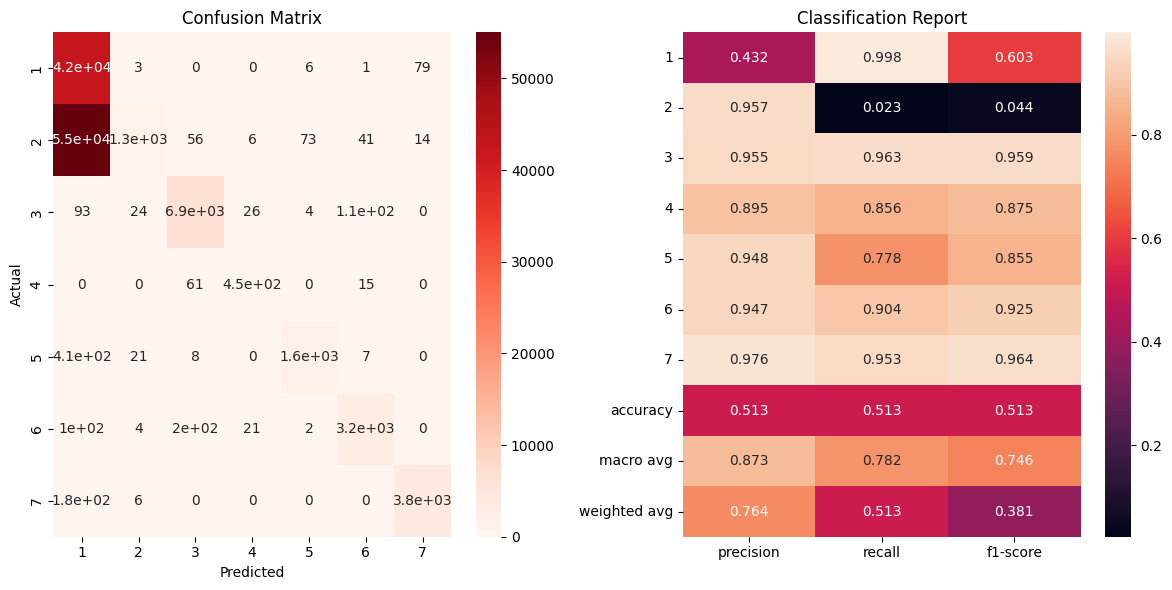

Accuracy: 0.512818085591594


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.51282
f1-score_avg,0.38088
precision_avg,0.76437
recall_avg,0.51282


In [490]:
# Evaluate KNN on all test data
pn = "pipeline-" + project_name
wandb.init(project=pn, name="final")

# Modify the list and extract the second element in one step
# final_knn_predictions = [t[0] for t in knn_predictions] # New
final_knn_predictions = [(lambda t: (t[0], NORMAL_TARGET, t[2]) if t[0] == 1 else t)(t)[1] for t in knn_predictions] # Old
final_knn_predictions_df = pd.DataFrame(final_knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()